In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
sns.set_style('dark', { 'axes.spines.right': False, 'axes.spines.top': False})

In [7]:
# load data
df = pd.read_csv("./data/milling_failure.csv") 
df = df[df['Machine failure']!=0]
df.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
50,51,L47230,L,298.9,309.1,2861,4.6,143,1,0,0,1,0,0
69,70,L47249,L,298.9,309.0,1410,65.7,191,1,0,0,1,1,0
77,78,L47257,L,298.8,308.9,1455,41.3,208,1,1,0,0,0,0
160,161,L47340,L,298.4,308.2,1282,60.7,216,1,0,0,0,1,0
161,162,L47341,L,298.3,308.1,1412,52.3,218,1,0,0,0,1,0


In [ ]:
# this is an encoded dataset, we need to decode it
enc_failure = df.iloc[:,-5:] # get the encoded failure data; the last 5 columns
data = df.iloc[:,3:-6] # get the data; ignoring product data in the first 3 columns and the encoded failure data

In [21]:
# We remove rows with no failure; 
# if all [5] coded failure columns are 0 (means no failure), remove the row
indices_to_remove = enc_failure.index[(enc_failure == 0).sum(axis=1) > 4]
# more complicated approach using apply and lambda (called anonymous function):
# indices_to_remove = enc_failure.index[enc_failure.apply(lambda row: (row == 0).sum(), axis=1) > 4]
enc_failure = enc_failure.drop(indices_to_remove)
data = data.drop(indices_to_remove)
indices_to_remove = enc_failure.index[enc_failure.apply(lambda row: (row == 1).sum(), axis=1) > 1]
enc_failure = enc_failure.drop(indices_to_remove)
data = data.drop(indices_to_remove)

# create categorical data from encoded data:
df_cat = pd.from_dummies(enc_failure)

df = pd.concat([data, df_cat],axis=1)
df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],
50,298.9,309.1,2861,4.6,143,PWF
77,298.8,308.9,1455,41.3,208,TWF
160,298.4,308.2,1282,60.7,216,OSF
161,298.3,308.1,1412,52.3,218,OSF
168,298.4,308.3,1433,62.3,20,PWF


In [22]:
# define the target
df.rename(columns={'Air temperature [K]': 'air_temperature', 
                        'Process temperature [K]': 'process_temperature', 
                        'Rotational speed [rpm]':'rotational_speed', 
                        'Torque [Nm]': 'torque', 
                        'Tool wear [min]': 'tool_wear'
                        ,df.columns[-1]: 'Failure'}, inplace=True)

# drop a redundant columns
# df.drop(columns=['Target'], inplace=True)

# print a summary of the train data
# print(df.shape[0])
# df.columns

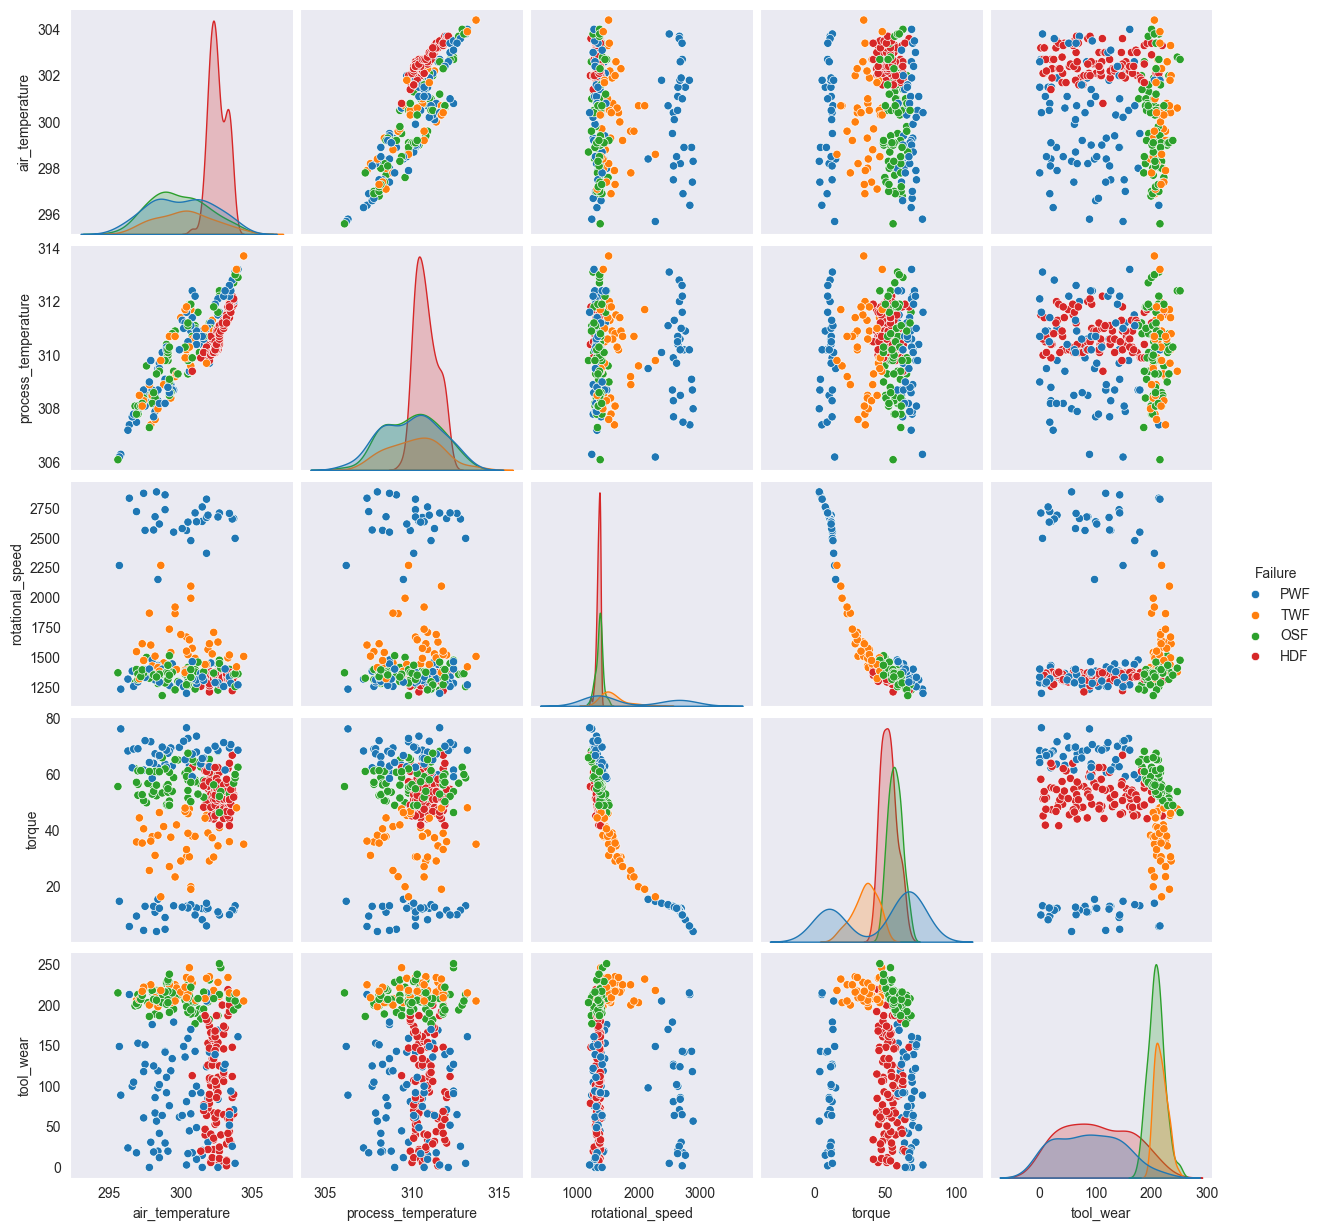

In [23]:
# px.histogram(df,y='Failure', color='Failure')
sns.pairplot(df,hue='Failure')
#  Failure types {power, toolwear, overstrain, heat}

In [51]:
df.columns

Index(['air_temperature', 'process_temperature', 'rotational_speed', 'torque',
       'tool_wear', 'Failure'],
      dtype='object')

<Axes: xlabel='torque', ylabel='Count'>

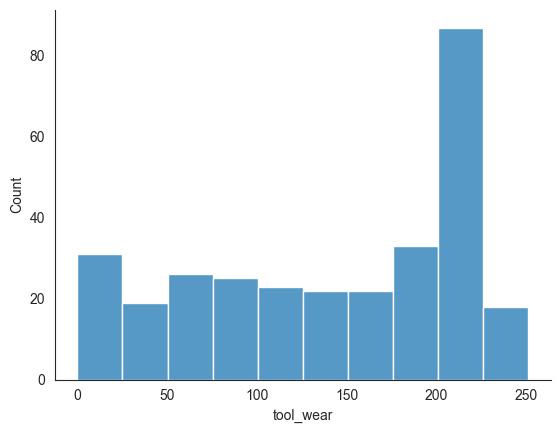

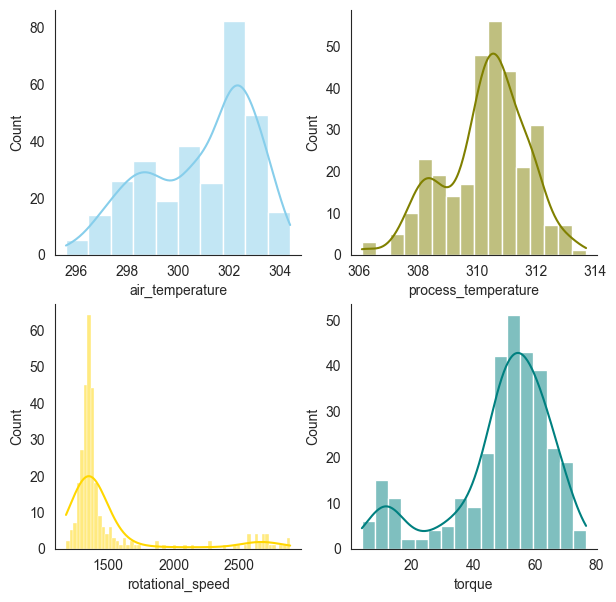

In [52]:
sns.histplot(df['tool_wear'])
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

sns.histplot(data=df, x="air_temperature", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df, x="process_temperature", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df, x="rotational_speed", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df, x="torque", kde=True, color="teal", ax=axs[1, 1])

Bayesian Networks in pgmpy primarily work with categorical data or with distributions explicitly defined for continuous variables. For numerical data, you often need to discretize the variables or use a model that can handle continuous distributions explicitly.

pgmpy supports models with continuous nodes using specific distributions (e.g., Gaussian distributions for each node), but constructing and working with these models is more complex than with discrete variables, and it requires defining the parents' relationships and the conditional probability distributions (CPDs) manually. For a basic approach with numerical data and Bayesian Networks, discretizing your numerical data into categorical bins might be the simplest way to proceed. However, this could lead to loss of information and isn't the most sophisticated method for handling numerical data.

For an easier calculation of conditional probabilities based on counts of occurences, we can bin the data based on the distributions we see in the graphs above

In [24]:
# df columns: ['air_temperature', 'process_temperature', 'rotational_speed', 'torque','tool_wear', 'Failure']
df_bayes = pd.DataFrame()
df_bayes['air_temperature'] = pd.cut(df['air_temperature'], bins=[0,299,302,max(df['air_temperature'])], labels=['low', 'mid', 'high'])
df_bayes['process_temperature'] = pd.cut(df['process_temperature'], bins=[0,310,max(df['process_temperature'])], labels=['low','high'])
df_bayes['rotational_speed'] = pd.cut(df['rotational_speed'], bins=[0,1500,max(df['rotational_speed'])], labels=['low','high'])
df_bayes['torque'] = pd.cut(df['torque'], bins=[0,45,max(df['torque'])], labels= ['low', 'high'])
df_bayes['tool_wear'] = pd.cut(df['tool_wear'], bins=[0,200, max(df['tool_wear'])], labels= ['low', 'high'])
df_bayes['Failure'] = df['Failure']
df_bayes['Failure'].value_counts()

Failure
HDF    106
PWF     80
OSF     78
TWF     42
Name: count, dtype: int64

In [25]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination

In [26]:
# Defining the model structure. We assume all variables directly influence 'Failure'
model = BayesianModel([
    ('air_temperature', 'Failure'),
    ('process_temperature', 'Failure'),
    ('rotational_speed', 'Failure'),
    ('torque', 'Failure'),
    ('tool_wear', 'Failure')
])

# Learning the parameters using Maximum Likelihood Estimator
model.fit(df_bayes, estimator=MaximumLikelihoodEstimator)

# For predictions, you can use the VariableElimination inference algorithm
inference = VariableElimination(model)
                              


In [27]:
# Example of querying the 'Failure' given some evidence:
query_result = inference.query(variables=['Failure'], 
                               evidence={
                                   'air_temperature': 'mid',
                                   'process_temperature': 'low',
                                   'rotational_speed': 'high',
                                   'torque': 'low',
                                   'tool_wear': 'high'})
print(query_result)

+--------------+----------------+
| Failure      |   phi(Failure) |
+==============+================+
| Failure(HDF) |         0.0000 |
+--------------+----------------+
| Failure(OSF) |         0.0000 |
+--------------+----------------+
| Failure(PWF) |         0.0000 |
+--------------+----------------+
| Failure(TWF) |         1.0000 |
+--------------+----------------+


Let's consider a more complicated example where we have the following network (to draw it we will use the networkx graph visualization library in addition to matplotlib; to install: `pip install networkx`)

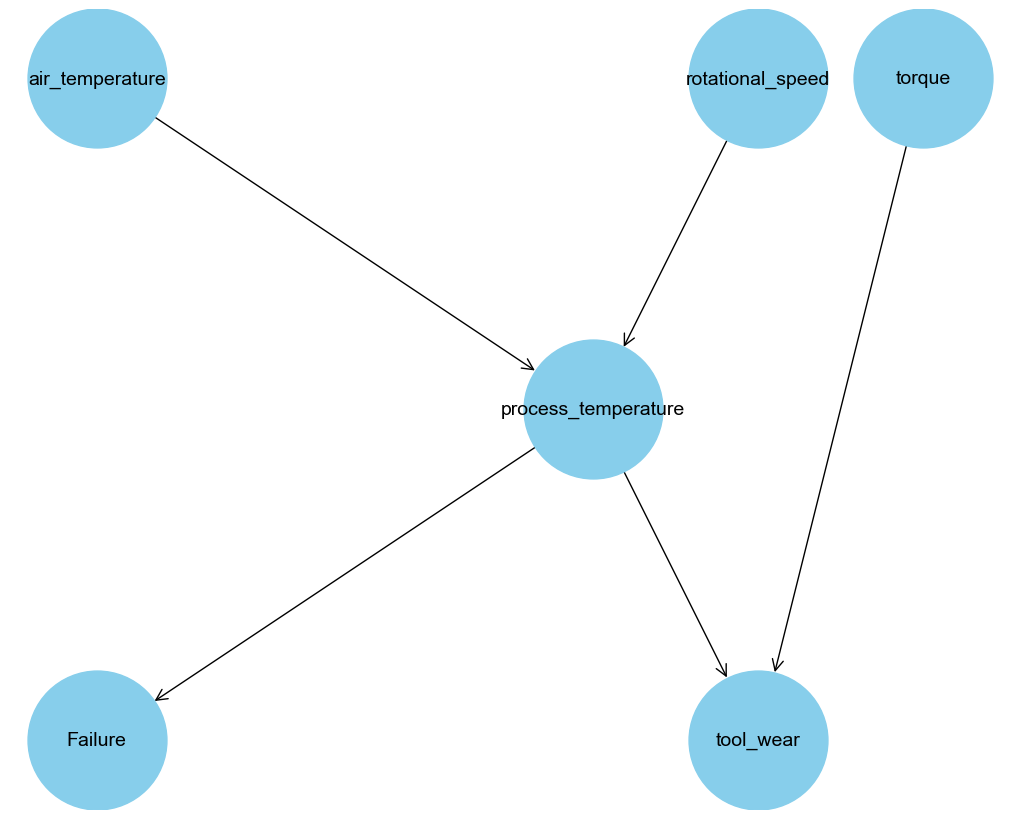

In [28]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges based on the given structure
edges = [
    ('air_temperature', 'process_temperature'),
    ('rotational_speed', 'process_temperature'),
    ('process_temperature', 'Failure'),
    ('torque', 'tool_wear'),
    ('process_temperature', 'tool_wear')
]

G.add_edges_from(edges)

# Manually define node positions
pos = {
    'air_temperature': (-1, 2),
    'rotational_speed': (1, 2),
    'process_temperature': (0.5, 1),
    'Failure': (-1, 0),
    'torque': (1.5, 2),
    'tool_wear': (1, 0)
}

plt.figure(figsize=(10,8))

# Draw the graph with manually defined positions
nx.draw(G, pos, with_labels=True, node_size=10000, node_color='skyblue', font_size=14, arrows=True, arrowstyle='->', arrowsize=20)

plt.axis('off')  # Turn off the axis to make it cleaner
plt.show()  # Display the graph


In [29]:
# Defining the new model structure. 
# We write pairs of parent-child nodes to define the edges of the graph.
model = BayesianModel([
    ('air_temperature', 'process_temperature'),
    ('rotational_speed', 'process_temperature'),
    ('process_temperature', 'Failure'),
    ('torque', 'tool_wear'),
    ('process_temperature', 'tool_wear')
])

# Learning the parameters using Maximum Likelihood Estimator
model.fit(df_bayes, estimator=MaximumLikelihoodEstimator)

# For predictions, you can use the VariableElimination inference algorithm
inference = VariableElimination(model)

                              


In [30]:
# Example of querying the 'tool wear' and 'Failure' given some evidence:
query_result = inference.query(variables=['tool_wear', 'Failure'], 
                               evidence={
                                   'air_temperature': 'mid',
                                   'process_temperature': 'low',
                                   'rotational_speed': 'high',
                                   'torque': 'low'})
print(query_result)

+-----------------+--------------+--------------------------+
| tool_wear       | Failure      |   phi(tool_wear,Failure) |
+=================+==============+==========================+
| tool_wear(high) | Failure(HDF) |                   0.0343 |
+-----------------+--------------+--------------------------+
| tool_wear(high) | Failure(OSF) |                   0.1863 |
+-----------------+--------------+--------------------------+
| tool_wear(high) | Failure(PWF) |                   0.1814 |
+-----------------+--------------+--------------------------+
| tool_wear(high) | Failure(TWF) |                   0.0980 |
+-----------------+--------------+--------------------------+
| tool_wear(low)  | Failure(HDF) |                   0.0343 |
+-----------------+--------------+--------------------------+
| tool_wear(low)  | Failure(OSF) |                   0.1863 |
+-----------------+--------------+--------------------------+
| tool_wear(low)  | Failure(PWF) |                   0.1814 |
+-------